<a href="https://colab.research.google.com/github/pinkdolphin11/ESAA/blob/main/HW_0902.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chapter 3. 분류

In [1]:
#matplotlib 한글 깨짐 방지
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

In [2]:
#matplotlib 한글 깨짐 방지
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') 

### 3.1 MNIST

In [3]:
#MNIST 데이터셋 내려받기

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False) #as_frame=False 지정해야 X[0] 실행됨
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

사이킷런에서 읽어들인 데이터셋들의 일반적인 딕셔너리 구조

* DESCR 키 : 데이터셋을 설명
* data 키 : 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가짐
* target 키 : 레이블 배열을 담고있음

In [4]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


X, y 배열의 특징

* 이미지 70,000개, 각 이미지에 784개의 특성이 있음
* 28X28 픽셀
* 개개의 특성은 0(흰색)부터 255(검은색)까지의 픽셀 강도를 나타냄

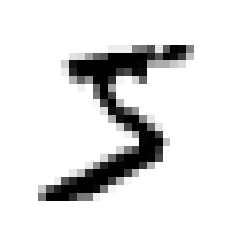

In [5]:
#데이터셋에서 이미지 하나 확인

import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0] #샘플의 특성 벡터 추출
some_digit_image = some_digit.reshape(28, 28) #28X28 배열로 크기 변경

plt.imshow(some_digit_image, cmap="binary") #matplotlib imshow() 함수로 그림
plt.axis("off")
plt.show()

In [6]:
y[0]

'5'

그림에 나타난 모양과 실제 레이블 값이 일치한다.

In [7]:
#레이블은 문자열이므로 y 정수변환

import numpy as np
y = y.astype(np.uint8)

In [8]:
#train, test 데이터 만들기
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

참고

* MNIST 데이터셋은 train set(앞 60,000개 이미지)와 
test set(뒤 10,000개 이미지)로 이미 나누어져 있음
* train set는 이미 섞여 있어서 모든 교차 검증 폴드를 비슷하게 만듦
* 어떤 학습 알고리즘은 train 샘플의 순서에 민감해서 많은 비슷한 샘플이 연이어 나타나면 성능이 나빠지는데, 데이터셋을 섞으면 이를 방지할 수 있음


### 3.2 이진 분류기 훈련

이진 분류기 예시 : 하나의 숫자(ex. 5)만 식별. '5'와 '5 아님' 2개의 클래스를 구분 가능

In [9]:
#분류 작업을 위한 타깃 벡터 만들기

y_train_5 = (y_train == 5) #5는 True고, 다른 숫자는 모두 False
y_test_5 = (y_test == 5)

SGDClassifier 클래스를 사용한 확률적 경사 하강법(SGD) 분류 모델을 선택하여 훈련시킴

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42) #무작위성을 사용하여 훈련하므로 결과 재현을 위해 random_state 지정
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [11]:
#이 모델로 숫자 5의 이미지 감지
sgd_clf.predict([some_digit])

array([ True])

분류기는 이 이미지가 5를 나타낸다고 추측함(True)

### 3.3 성능 측정

#### 3.3.1 교차 검증을 사용한 정확도 측정

사이킷런이 제공하는 기능보다 교차 검증 과정을 더 많이 제어해야 할 때는 교차 검증 기능을 직접 구현하면 된다. 다음은 사이킷런의 cross_val_score() 함수와 거의 같은 작업을 수행하고 동일한 결과를 출력하는 코드이다.

In [12]:
from sklearn.model_selection import StratifiedKFold #클래스별 비율이 유지되도록 폴드를 만들기 위해 계층적 샘플링 수행
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5): #매 반복에서 분류기 객체를 복제하여 훈련 폴드로 훈련시키고 테스트 폴드로 예측을 만듦
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train[test_index]
  y_test_fold = y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct / len(y_pred)) #올바른 예측의 수를 세어 정확한 예측의 비율 출력

0.9669
0.91625
0.96785


cross_val_score() 함수로 폴드가 3개인 k-겹 교차 검증을 사용해 SGDClassifier 모델 평가. k-겹 교차 검증은 훈련 세트를 k개의 폴드로 나누고 각 폴드에 대해 예측을 만들고 평가하기 위해 나머지 폴드로 훈련시킨 모델 사용

In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

모든 교차 검증 폴드에 대해 정확도가 95% 이상이다.

In [14]:
#모든 이미지를 '5 아님' 클래스로 분류하는 더미 분류기를 만들어 비교

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    return self
  def predict(self, X):
    return np.zeros((len(X),1),dtype=bool)

In [15]:
#모델의 정확도 추측

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

정확도가 90% 이상이다. 이미지의 10% 정도만 숫자 5이기 때문에 무조건 '5 아님'으로 예측하면 정확히 맞출 확률이 90%인 것이다. 정확도를 분류기의 성능 측정 지표로 선호하지 않는 이유가 여기에 있다. 특히 불균형한 데이터셋을 다룰 때(어떤 클래스가 다른 것보다 월등히 많은 경우) 더욱 그렇다.

#### 3.3.2 오차 행렬

성능 평가의 더 좋은 방법은 오차행렬이다. 기본적인 아이디어는 클래스 A의 샘플이 클래스 B로 분류된 횟수를 세는 것이다. 예를 들어 분류기가 숫자 5의 이미지를 3으로 잘못 분류한 횟수를 알고 싶다면 오차 행렬의 5행 3열을 보면 된다.

오차 행렬을 만들려면 실제 타깃과 비교할 수 있도록 예측값을 만들어야 하는데, 테스트 세트로 만든 예측은 사용하면 안 된다. 대신 cross_val_predict() 함수를 사용할 수 있다.

In [16]:
from sklearn.model_selection import cross_val_predict #k-겹 교차 검증을 수행하지만 평가 점수가 아니라 각 테스트 폴드에서 얻은 예측을 반환(훈련 세트의 모든 샘플에 대한 깨끗한 예측)

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [17]:
from sklearn.metrics import confusion_matrix #오차행렬 만드는 함수
confusion_matrix(y_train_5, y_train_pred) #타깃 클래스와 예측 클래스를 넣고 호출

array([[53892,   687],
       [ 1891,  3530]])

오차행렬

* 행 : 실제 클래스
* 열 : 예측한 클래스

위 예시에서

* 첫번째 행 : '5 아님' 이미지(negative class 음성 클래스). 53892개를 '5 아님'으로 정확하게 분류(true negative 진짜 음성), 687개는 '5'라고 잘못 분류(false positive 거짓 양성)

* 두번째 행 : '5' 이미지(positive class 양성 클래스). 1891개를 '5 아님'으로 잘못 분류(false negative 거짓 음성), 3530개를 정확히 '5'로 분류(true positive 진짜 양성)


In [18]:
y_train_perfect_predictions = y_train_5 #완벽한 분류기일 경우
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

오차 행렬보다 요약된 지표가 필요할 때 양성 예측의 정확도를 살펴본다. 이를 분류기의 정밀도라고 한다.

* 정밀도 = TP/(TP+FP)

분류기가 정확하게 감지한 양성 샘플의 비율인 재현율과 함께 사용한다.

* 재현율 = TP/(TP+FN)

#### 3.3.3 정밀도와 재현율

In [19]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) #3530/(3530+687)

0.8370879772350012

In [20]:
recall_score(y_train_5, y_train_pred) #3530/(3530+1891)

0.6511713705958311

F1 score : 정밀도와 재현율의 조화평균

In [21]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

정밀도와 재현율이 비슷한 분류기에서 f1 score가 높지만, 상황에 따라 정밀도나 재현율 중 하나가 더 중요할 수 있으므로 이것이 항상 바람직하지는 않다. 어린이에게 안전한 동영상을 걸러내는 분류기를 훈련시킬 경우, 재현율은 높으나 정말 나쁜 동영상이 몇 개 노출되는 것보다 좋은 동영상이 많이 제외되더라도(낮은 재현율) 안전한 것들만 노출시키는(높은 정밀도) 분류기를 선호할 것이다.


#### 3.3.4 정밀도/재현율 트레이드오프

SGDClassifier는 결정 함수를 사용하여 각 샘플의 점수를 계산한다. 점수가 임곗값보다 크면 샘플을 양성 클래스, 아니면 음성 클래스에 할당한다. 임곗값이 높을수록 재현율은 낮아지고 반대로 정밀도는 높아진다.

사이킷런에서 임곗값을 직접 지정할 수는 없지만 예측에 사용한 점수는 확이할 수 있다. predict() 대신 decision_function()을 호출하면 각 샘플의 점수를 얻을 수 있고, 이를 기반으로 원하는 임곗값을 정해 예측을 만들 수 있다.

In [22]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [23]:
threshold = 0 #임곗값 설정
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred #임곗값이 0이므로 predict() 메서드와 같은 결과 반환

array([ True])

In [24]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

임곗값을 높이면 재현율이 줄어든다. 이미지가 실제로 숫자 5이고, 임곗값이 0일 때는 분류기가 이를 감지했지만 8000으로 높이면 이를 놓친다.

In [25]:
#적절한 임곗값 정하기 : 훈련 세트에 있는 모든 샘플의 점수를 구하는데 결정 점수를 반환받도록 지정

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [26]:
#위 점수로 가능한 모든 임곗값에 대한 정밀도와 재현율 계산

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


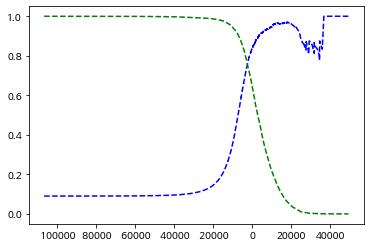

In [27]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label="정밀도")
  plt.plot(thresholds, recalls[:-1], "g--", label="재현율")

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

정밀도 곡선이 재현율 곡선보다 울퉁불퉁한것은 임곗값을 올려도 정밀도가 낮아지는 경우가 있기 때문이다.

재현율에 대한 정밀도 곡선을 그려서 좋은 정밀도/재현율 트레이드오프를 선택한다. 정밀도가 급격하게 줄어드는 하강점 직전을 선택하는 것이 좋다.

In [28]:
#정밀도 90%를 달성하고자 할 때 가장 낮은 임곗값 찾기

threshold_90_precision = thresholds[np.argmax(precisions>=0.90)] #np.argmax() : 최댓값의 첫 번째 인덱스 반환(첫 번째 True 값)
threshold_90_precision

3370.0194991439557

In [29]:
#훈련 세트에 대한 예측 만들기
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [30]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [31]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

#### 3.3.5 ROC 곡선

거짓 양성 비율에 대한 진짜 양성 비율(재현율의 다른 이름)의 곡선

거짓 양성 비율 : 양성으로 잘못 분류된 음성 샘플의 비율(FPR)인데, 1에서 음성으로 정확하게 분류한 음성 샘플의 비율인 진짜 음성 비율(TNR)을 뺀 값이다. TNR을 특이도라고 하므로, ROC 곡선은 민감도(재현율)에 대한 1-특이도 그래프이다.

In [32]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

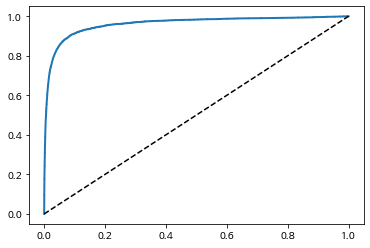

In [33]:
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0,1],[0,1],'k--') #대각 점선

plot_roc_curve(fpr, tpr)
plt.show()

재현율이 높을수록 분류기가 만드는 거짓 양성이 늘어난다. 점선은 완전한 랜덤 분류기의 ROC곡선이다. 좋은 분류기는 이 점선에서 최대한 멀리 떨어져 있어야 한다.

곡선 아래의 면적(AUC)을 측정하여 분류기를 비교할 수 있다.

* 완벽한 분류기 : AUC = 1
* 완전한 랜덤 분류기 : AUC = 0.5

In [34]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

RandomForestClassifier를 훈련시켜 SGDClassifier의 ROC 곡선과 AUC 점수를 비교하자.

In [35]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method = "predict_proba") #predict_proba : 훈련 세트의 샘플에 대한 점수 얻음. 샘플이 행, 클래스가 열이고 샘플이 주어진 클래스에 속할 확률을 담은 배열 반환

In [36]:
y_scores_forest = y_probas_forest[:,1] #양성 클래스에 대한 확률을 점수로 사용
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

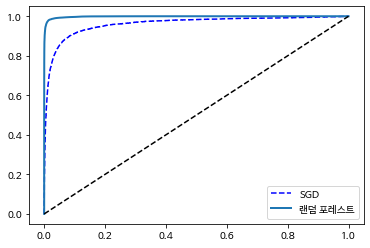

In [37]:
plt.plot(fpr,tpr,"b--",label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, "랜덤 포레스트")
plt.legend(loc="lower right")
plt.show()

In [38]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

### 3.4 다중 분류

다중 분류기는 둘 이상의 클래스를 구별할 수 있다.

SGD, 랜덤포레스트, 나이브 베이즈 : 여러 개의 클래스를 직접 처리 가능

로지스틱 회귀, 서포트 벡터 머신 분류기 : 이진 분류만 가능하지만 이진 분류기를 여러 개 사용해 다중 클래스를 분류하면 됨

ex. 특정 숫자 하나만 구분하는 숫자별 이진 분류기 10개(0부터 9까지)를 훈련시켜 클래스가 10개인 숫자 이미지 분류 시스템을 만들 수 있다. 이미지를 분류할 때 각 분류기의 결정 점수 중에서 가장 높은 것을 클래스로 선택하는데, 이를 OvR(OvA)라고 한다.

0과 1 구별, 0과 2 구별, 1과 2 구별처럼 각 숫자의 조합마다 이진 분류기를 훈련시키는 방법도 있는데, 이를 OvO라고 한다. 클래스가 N개이면 분류기는 NX(N-1)/2개가 필요하다. 이미지 하나를 분류하려면 모든 분류기를 통과시켜서 가장 많이 양성으로 분류된 클래스를 선택하면 된다. 각 분류기의 훈련에 전체 훈련 세트 중 구별할 두 클래스에 해당하는 샘플만 필요하다는 장점이 있다. 하지만 대부분 OvR을 선호한다.

In [39]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

다중 클래스 분류 작업에 이진 분류 알고리즘을 선택하면 사이킷런이 알고리즘에 따라 자동으로 OvR 또는 OvO를 실행한다. 이 코드는 5를 구별한 타깃 클래스 대신 0에서 9까지의 원래 타깃 클래스를 사용해 SVC를 훈련시킨다.

In [40]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

위에서 설명한 이유로 인해 샘플당 10개의 점수를 반환한다. 이 점수는 클래스마다 하나씩이다. 가장 높은 점수가 클래스 5에 해당하는 값이다.

In [42]:
np.argmax(some_digit_scores)

5

In [43]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [44]:
svm_clf.classes_[5]

5

강제로 OvO나 OvR을 사용하려면 간단하게 이진 분류기 인스턴스를 만들어 객체를 생성할 때 전달하면 된다. 다음 코드는 SVC 기반 OvR 전략을 사용하는 다중 분류기를 만든다.

In [46]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [47]:
len(ovr_clf.estimators_)

10

In [48]:
sgd_clf.decision_function([some_digit])

array([2164.22030239])

분류기가 예측 결과에 강한 확신을 보임을 알 수 있다. 대부분의 점수가 큰 음수이고, 클래스 5의 점수는 이다.

In [49]:
#분류기 정확도 평가
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [50]:
#정확도 높이기
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

### 3.5 에러 분석

가능성이 높은 모델을 하나 찾았다고 가정하고 만들어진 에러의 종류를 분석하여 이 모델의 성능을 향상시켜 보자.

In [51]:
#오차행렬 살펴보기
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

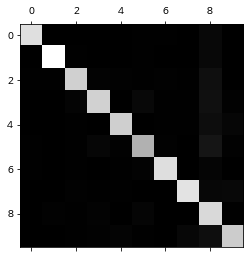

In [52]:
#보기 편하게 이미지로
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

대부분의 이미지가 올바르게 분류되었음을 나타내는 주대각선에 있다. 숫자 5는 다른 것보다 더 어두운데, 이는 데이터셋에 숫자 5의 이미지가 적거나 분류기가 숫자 5를 다른 숫자만큼 잘 분류하지 못한다는 뜻이다. 두 경우 모두 확인해 봐야 한다.

In [53]:
#오차 행렬을 각 값을 대응되는 클래스의 이미지 개수로 나누어 에러 비율 비교

row_sums = conf_mx.sum(axis=1,keepdims=True)
norm_conf_mx = conf_mx / row_sums

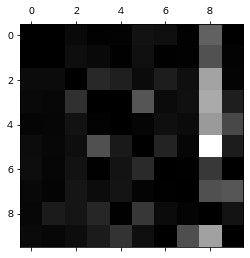

In [54]:
#주대각선만 0으로 채워서 그래프 그리기

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

분류기가 만든 에러를 확실히 볼 수 있다. 행은 실제 클래스, 열은 예측한 클래스를 나타낸다. 클래스 8의 열이 상당히 밝으므로 많은 이미지가 8로 잘못 분류된 것이다. 하지만 클래스 8의 행은 나쁘지 않다. 이는 실제 8이 적절히 8로 분류되었다는 것이다. 오차 행렬은 반드시 대칭이 아니다. 또한 3과 5가 많이 혼동되고 있는 것도 볼 수 있다.

이를 개선하기 위해 8처럼 보이지만 실제 8은 아닌 숫자의 훈련 데이터를 더 모아서 실제 8과 구분하도록 분류기를 학습시킬 수 있다.

In [56]:
# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # n_rows = ceil(len(instances) / images_per_row) 와 동일합니다:
    n_rows = (len(instances) - 1) // images_per_row + 1

    # 필요하면 그리드 끝을 채우기 위해 빈 이미지를 추가합니다:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # 배열의 크기를 바꾸어 28×28 이미지를 담은 그리드로 구성합니다:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # 축 0(이미지 그리드의 수직축)과 2(이미지의 수직축)를 합치고 축 1과 3(두 수평축)을 합칩니다. 
    # 먼저 transpose()를 사용해 결합하려는 축을 옆으로 이동한 다음 합칩니다:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # 하나의 큰 이미지를 얻었으므로 출력하면 됩니다:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

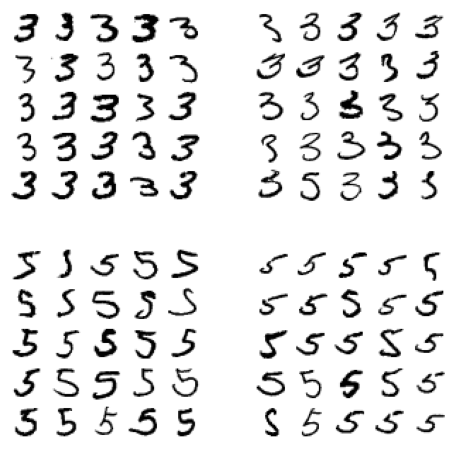

In [57]:
#개별 에러를 분석 - 3과 5의 샘플 그리기

cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

왼쪽의 5X5 블록 2개 : 3으로 분류된 이미지
오른쪽 블록 2개 : 5로 분류된 이미지

선형 모델인 SGDClassifier를 사용해서 오류가 발생한 것이다. 선형 분류기는 클래스마다 픽셀에 가중치를 할당하고 새로운 이미지에 대해 단순히 픽셀 강도의 가중치 합을 클래스의 점수로 계산하므로, 3과 5는 몇 개의 픽셀만 달라서 모델이 쉽게 혼동할 수 있다.

### 3.6 다중 레이블 분류

지금까지는 각 샘플이 하나의 클래스에만 할당되었다. 하지만 분류기가 샘플마다 여러 개의 클래스를 출력해야 할 때도 있다. 예를 들어 같은 사진에 여러 사람이 등장하면 인식된 사람마다 하나씩 꼬리표를 붙여야 한다. 여러 개의 이진 꼬리표를 출력하는 분류 시스템을 다중 레이블 분류라고 한다.

In [58]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

각 숫자 이미지에 두 개의 타깃 레이블이 담긴 y_multilabel 배열을 만들었다. 첫 번째는 숫자가 큰 값인지 나타내고, 두 번째는 홀수인지 나타낸다. 그다음 줄이 KNeighborsClassifier 인스턴스를 만들고 다중 타깃 배열을 사용하여 훈련시킨다.

In [59]:
knn_clf.predict([some_digit]) #예측을 만들면 레이블 2개 출력

array([[False,  True]])

숫자 5는 7보다 작고 홀수이므로 바르게 분류되었다.

In [61]:
#평가
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.976410265560605

### 3.7 다중 출력 분류

다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화한 것이다. 즉 값을 2개 이상 가질 수 있다.

이미지에서 잡음을 제거하는 시스템을 만들어 보자. 잡음이 많은 숫자 이미지를 입력으로 받고 깨끗한 숫자 이미지를 MNIST 이미지처럼 픽셀의 강도를 담은 배열로 출력한다. 분류기의 출력이 다중 레이블(픽셀당 한 레이블)이고 각 레이블은 값을 여러 개 가진다.(0부터 255까지)

In [62]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [63]:
# 그림 그리는 기능을 함수로 만들어두자.
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

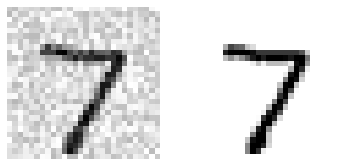

In [66]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

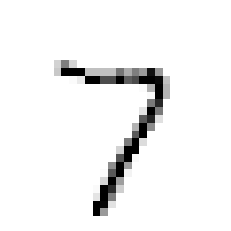

In [64]:
some_index = 0
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)